In [1]:
import warnings
warnings.filterwarnings('ignore')
from dotenv import load_dotenv
import os

# Cargar las variables de entorno desde el archivo .env
load_dotenv()

True

In [2]:
import mlflow
from pathlib import Path
from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
#from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
try:
    # Intentar leer el archivo localmente
    data = pd.read_csv('../data/Steel_industry_data.csv')
except FileNotFoundError:
    # Si no se encuentra, leer desde la URL
    data = pd.read_csv('https://raw.githubusercontent.com/luis-huacho/INF648-Proy-Curso-2024-01/main/data/Steel_industry_data.csv')

# Seleccionar las columnas para la regresión
features = data.drop(columns=['date', 'Usage_kWh'])
target = data['Usage_kWh']

In [4]:
# Obtener la URI de seguimiento de MLflow
mlflow_tracking_uri = os.getenv("MLFLOW_TRACKING_URI")

if not mlflow_tracking_uri:
    # Preguntar al usuario por la dirección si no se encuentra la variable de entorno
    mlflow_tracking_uri = input("Ingrese la dirección de MLflow: ")

# Configurar la URI de seguimiento de MLflow
mlflow.set_tracking_uri(mlflow_tracking_uri)

# Nombre del experimento
experiment_name = "Regresion_Lineal"

# Crear un experimento de MLflow
experiment_id = mlflow.create_experiment(experiment_name) if not mlflow.get_experiment_by_name(experiment_name) else mlflow.get_experiment_by_name(experiment_name).experiment_id

# Iniciar un nuevo run de MLflow
with mlflow.start_run(experiment_id=experiment_id):
    # Codificación de variables categóricas
    categorical_features = ['WeekStatus', 'Day_of_week', 'Load_Type']
    numerical_features = features.drop(columns=categorical_features).columns.tolist()
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(), categorical_features)
        ]
    )
    
    # Crear el modelo de regresión lineal
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', LinearRegression())])
    
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Realizar predicciones
    y_pred = model.predict(X_test)
    
    
    # Evaluar el modelo escalado
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Registrar métricas en MLflow
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R^2 Score: {r2}')
    
    # Registrar el modelo en MLflow
    mlflow.sklearn.log_model(model, "model")
    

Mean Squared Error (MSE): 17.842279082768904
Root Mean Squared Error (RMSE): 4.22401220201468
Mean Absolute Error (MAE): 2.5337743872429765
R^2 Score: 0.984303749042813


In [5]:
# Obtener los coeficientes y el intercepto del modelo escalado
coefficients = model.named_steps['regressor'].coef_
intercept = model.named_steps['regressor'].intercept_

In [6]:
# Obtener los nombres de las características después del procesamiento
feature_names = numerical_features + list(model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
print(feature_names)

['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'WeekStatus_Weekday', 'WeekStatus_Weekend', 'Day_of_week_Friday', 'Day_of_week_Monday', 'Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday', 'Day_of_week_Tuesday', 'Day_of_week_Wednesday', 'Load_Type_Light_Load', 'Load_Type_Maximum_Load', 'Load_Type_Medium_Load']


In [7]:
df = pd.DataFrame(list(zip(feature_names, coefficients)), columns=['Feature', 'Coefficient'])
df 

,Feature,Coefficient
0,Lagging_Current_Reactive.Power_kVarh,5.326760
1,Leading_Current_Reactive_Power_kVarh,0.527344
2,CO2(tCO2),26.470446
3,Lagging_Current_Power_Factor,2.307306
4,Leading_Current_Power_Factor,1.850971
5,NSM,-0.071600
6,WeekStatus_Weekday,-0.013901
7,WeekStatus_Weekend,0.013901
8,Day_of_week_Friday,-0.155507
9,Day_of_week_Monday,-0.136342


In [8]:
# Imprimir la ecuación lineal
equation = f'y = {intercept:.2f} ' # Intercepto
for coef, name in zip(coefficients, feature_names):
    equation += f'+ ({coef:.2f} * {name}) '

print("Ecuación lineal del modelo:")
print(equation)

Ecuación lineal del modelo:
y = 27.56 + (5.33 * Lagging_Current_Reactive.Power_kVarh) + (0.53 * Leading_Current_Reactive_Power_kVarh) + (26.47 * CO2(tCO2)) + (2.31 * Lagging_Current_Power_Factor) + (1.85 * Leading_Current_Power_Factor) + (-0.07 * NSM) + (-0.01 * WeekStatus_Weekday) + (0.01 * WeekStatus_Weekend) + (-0.16 * Day_of_week_Friday) + (-0.14 * Day_of_week_Monday) + (-0.14 * Day_of_week_Saturday) + (0.15 * Day_of_week_Sunday) + (-0.22 * Day_of_week_Thursday) + (0.57 * Day_of_week_Tuesday) + (-0.08 * Day_of_week_Wednesday) + (-1.05 * Load_Type_Light_Load) + (0.28 * Load_Type_Maximum_Load) + (0.77 * Load_Type_Medium_Load) 


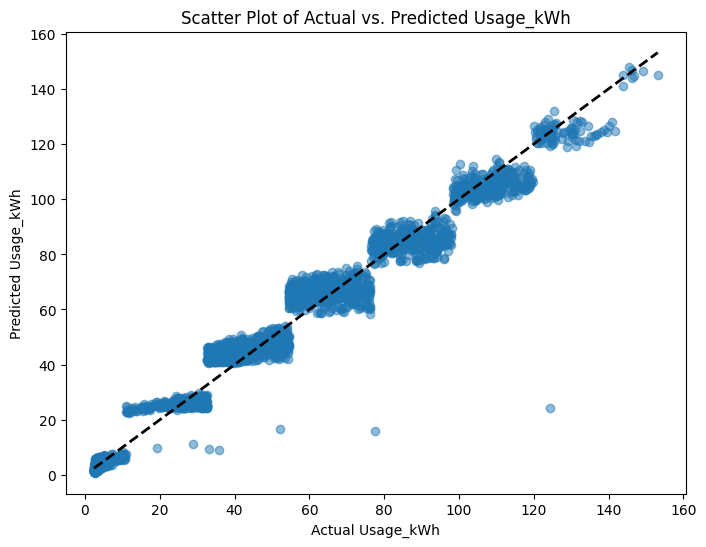

In [9]:
# Y real Vs Y pred 
plt.figure(figsize=(8, 6))
num_points = -1
plt.scatter(y_test[:num_points], y_pred[:num_points], alpha=0.5)
plt.xlabel('Actual Usage_kWh')
plt.ylabel('Predicted Usage_kWh')
plt.title('Scatter Plot of Actual vs. Predicted Usage_kWh')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()